<a href="https://colab.research.google.com/github/joaomariok/GeneticAlgorithmStudies/blob/main/GeneticAlgorithmStudies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from dataclasses import dataclass, replace

In [2]:
# ==================== Configuration ====================
@dataclass
class GAConfig:
    """Configuration class for Genetic Algorithm parameters.

    Attributes:
        num_tasks: Number of tasks to schedule
        num_machines: Number of available machines
        population_size: Size of the population
        generations: Number of generations to run
        crossover_rate: Probability of crossover occurring
        mutation_rate: Probability of mutation occurring
    """
    num_tasks: int
    num_machines: int
    population_size: int
    generations: int
    crossover_rate: float
    mutation_rate: float

In [3]:
# ==================== Evaluation Strategy ====================
class EvaluationStrategy(ABC):
    """Abstract base class for evaluation strategies."""
    @abstractmethod
    def evaluate(self, individual) -> float:
        """Evaluate the fitness of an individual solution.

        Args:
            individual: List where each element represents the machine assignment
                        for the corresponding task

        Returns:
            Fitness score (lower is better)
        """
        pass

class ClassicEvaluation(EvaluationStrategy):
    """Evaluates based solely on makespan (maximum machine load)."""
    NAME = "Classic"

    def __init__(self, tasks, num_machines):
        """Initialize evaluator with task durations and number of machines.

        Args:
            tasks: List of task durations
            num_machines: Number of available machines
        """
        self.tasks = tasks
        self.num_machines = num_machines

    def evaluate(self, individual):
        """Calculate fitness as the maximum machine load.

        Args:
            individual: Machine assignment for each task

        Returns:
            The makespan (maximum load on any machine)
        """
        machines = [0] * self.num_machines
        for i, m in enumerate(individual):
            machines[m] += self.tasks[i]
        return max(machines)

class ImprovedEvaluation(EvaluationStrategy):
    """Evaluates based on makespan plus load balancing factor."""
    NAME = "Improved"

    def __init__(self, tasks, num_machines):
        """Initialize evaluator with task durations and number of machines.

        Args:
            tasks: List of task durations
            num_machines: Number of available machines
        """
        self.tasks = tasks
        self.num_machines = num_machines

    def evaluate(self, individual):
        """Calculate fitness as makespan plus load balancing penalty.

        Args:
            individual: Machine assignment for each task

        Returns:
            Combined score considering both makespan and load balance
        """
        machines = [0] * self.num_machines
        for i, m in enumerate(individual):
            machines[m] += self.tasks[i]
        makespan = max(machines)
        avg = sum(machines) / self.num_machines
        deviation = sum(abs(x - avg) for x in machines) / self.num_machines
        return makespan + 0.1 * deviation

EVALUATION_STRATEGIES = [ClassicEvaluation.NAME, ImprovedEvaluation.NAME]

In [4]:
# ==================== Mutation Strategy ====================
class MutationStrategy(ABC):
    """Abstract base class for mutation strategies."""

    @abstractmethod
    def mutate(self, individual, tasks) -> list:
        """Mutate an individual solution.

        Args:
            individual: Solution to mutate
            tasks: List of task durations (for guided mutation)

        Returns:
            Mutated individual
        """
        pass

class NoMutation(MutationStrategy):
    """Null mutation strategy that returns the individual unchanged."""
    NAME = "NoMutation"

    def mutate(self, individual, tasks):
        """Return the individual without mutation.

        Args:
            individual: Solution to (not) mutate
            tasks: Unused in this implementation

        Returns:
            Original individual unchanged
        """
        return individual.copy()

class RandomMutation(MutationStrategy):
    """Random mutation that changes random genes."""
    NAME = "RandomMutation"

    def __init__(self, mutation_rate):
        """Initialize with mutation probability.

        Args:
            mutation_rate: Probability of mutating any given gene
        """
        self.mutation_rate = mutation_rate

    def mutate(self, individual, tasks):
        """Mutate by randomly changing genes based on mutation rate.

        Args:
            individual: Solution to mutate
            tasks: Unused in this implementation

        Returns:
            Potentially mutated individual
        """
        num_mutations = int(len(tasks) * self.mutation_rate)
        for _ in range(num_mutations):
            idx = random.randint(0, len(tasks) - 1)
            individual[idx] = random.randint(0, max(individual))
        return individual

class GuidedMutation(MutationStrategy):
    """Mutation that tries to balance machine loads."""
    NAME = "GuidedMutation"

    def __init__(self, mutation_rate):
        """Initialize with mutation probability.

        Args:
            mutation_rate: Probability of mutating any given gene
        """
        self.mutation_rate = mutation_rate

    def mutate(self, individual, tasks):
        """Mutate by moving tasks to less loaded machines.

        Args:
            individual: Solution to mutate
            tasks: Task durations needed for load calculation

        Returns:
            Mutated individual with potentially better load balance
        """
        num_mutations = int(len(tasks) * self.mutation_rate)
        machines = [0] * (max(individual) + 1)
        for i, m in enumerate(individual):
            machines[m] += tasks[i]

        for _ in range(num_mutations):
            idx = random.randint(0, len(tasks) - 1)
            best_machine = machines.index(min(machines))
            machines[individual[idx]] -= tasks[idx]
            individual[idx] = best_machine
            machines[best_machine] += tasks[idx]

        return individual

class SwapMutation(MutationStrategy):
    """Mutation that swaps two random genes."""
    NAME = "SwapMutation"

    def __init__(self, mutation_rate):
        self.mutation_rate = mutation_rate

    def mutate(self, individual, tasks):
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual

class ScrambleMutation(MutationStrategy):
    """Randomly scrambles a subset of genes."""
    NAME = "ScrambleMutation"

    def __init__(self, mutation_rate):
        self.mutation_rate = mutation_rate

    def mutate(self, individual, tasks):
        if random.random() < self.mutation_rate:
            start, end = sorted(random.sample(range(len(individual)), 2))
            subset = individual[start:end]
            random.shuffle(subset)
            individual[start:end] = subset
        return individual

MUTATION_STRATEGIES = [NoMutation.NAME, RandomMutation.NAME, GuidedMutation.NAME, SwapMutation.NAME, ScrambleMutation.NAME]

In [5]:
# ==================== Initialization Strategy ====================
class InitializationStrategy(ABC):
    """Abstract base class for population initialization strategies."""

    @abstractmethod
    def initialize_population(self, population_size: int) -> list:
        """Generate initial population.

        Args:
            population_size: Number of individuals to create

        Returns:
            List of initial solutions
        """
        pass

class RandomInitialization(InitializationStrategy):
    """Initializes population with random machine assignments."""
    NAME = "RandomInit"

    def __init__(self, num_tasks, num_machines):
        """Initialize with problem dimensions.

        Args:
            num_tasks: Number of tasks to schedule
            num_machines: Number of available machines
        """
        self.num_tasks = num_tasks
        self.num_machines = num_machines

    def initialize_population(self, population_size):
        """Create population with random assignments.

        Args:
            population_size: Number of individuals to create

        Returns:
            List of randomly generated solutions
        """
        return [[random.randint(0, self.num_machines - 1) for _ in range(self.num_tasks)]
                for _ in range(population_size)]

class GreedyInitialization(InitializationStrategy):
    """Initializes population with greedy solutions plus some random variants."""
    NAME = "GreedyInit"

    def __init__(self, tasks, num_machines, mutation_strategy: MutationStrategy, num_greedy=5):
        """Initialize with problem data and mutation strategy.

        Args:
            tasks: List of task durations
            num_machines: Number of available machines
            mutation_strategy: Strategy for creating variants of greedy solution
            num_greedy: Number of greedy-based individuals to include
        """
        self.tasks = tasks
        self.num_machines = num_machines
        self.num_greedy = num_greedy
        self.mutation_strategy = mutation_strategy

    def greedy_solution(self):
        """Create a single greedy solution.

        Returns:
            Solution created by always assigning to least loaded machine
        """
        machines = [0] * self.num_machines
        individual = []
        for t in self.tasks:
            idx = machines.index(min(machines))
            machines[idx] += t
            individual.append(idx)
        return individual

    def initialize_population(self, population_size):
        """Create population with mix of greedy and random solutions.

        Args:
            population_size: Total number of individuals to create

        Returns:
            Population containing greedy solutions and their variants
        """
        base_pop = [[random.randint(0, self.num_machines - 1) for _ in range(len(self.tasks))]
                    for _ in range(population_size - self.num_greedy)]
        base = self.greedy_solution()
        for _ in range(self.num_greedy):
            mutated = self.mutation_strategy.mutate(base[:], self.tasks)
            base_pop.append(mutated)
        return base_pop

INITIALIZATION_STRATEGIES = [RandomInitialization.NAME, GreedyInitialization.NAME]

In [6]:
# ==================== Selection Strategy ====================
class SelectionStrategy(ABC):
    """Abstract base class for selection strategies."""

    @abstractmethod
    def select(self, population, evaluator: EvaluationStrategy):
        """Select an individual from the population.

        Args:
            population: Current population of solutions
            evaluator: Fitness evaluation strategy

        Returns:
            Selected individual
        """
        pass

class TournamentSelection(SelectionStrategy):
    """Selects individuals through tournament competition."""
    NAME = "TournamentSelection"

    def select(self, population, evaluator: EvaluationStrategy):
        """Select between two randomly chosen individuals.

        Args:
            population: Current population
            evaluator: Used to compare fitness of individuals

        Returns:
            The better of two randomly selected individuals
        """
        a, b = random.sample(population, 2)
        return a if evaluator.evaluate(a) < evaluator.evaluate(b) else b

class RouletteWheelSelection(SelectionStrategy):
    """Fitness-proportional selection where better individuals have higher probability."""
    NAME = "RouletteWheelSelection"

    def select(self, population, evaluator: EvaluationStrategy):
        fitnesses = [1/(1+evaluator.evaluate(ind)) for ind in population]  # Inverse for minimization
        total = sum(fitnesses)
        probs = [f/total for f in fitnesses]
        return random.choices(population, weights=probs, k=1)[0]

class RankSelection(SelectionStrategy):
    """Selection based on rank rather than absolute fitness values."""
    NAME = "RankSelection"

    def select(self, population, evaluator: EvaluationStrategy):
        ranked = sorted(population, key=lambda x: evaluator.evaluate(x))
        ranks = range(1, len(population)+1)
        total = sum(ranks)
        probs = [r/total for r in ranks]
        return random.choices(ranked, weights=probs, k=1)[0]

class TournamentSelectionWithSize(SelectionStrategy):
    """Tournament selection with adjustable tournament size."""
    NAME = "TournamentSelectionWithSize"

    def __init__(self, tournament_size=3):
        self.tournament_size = tournament_size

    def select(self, population, evaluator: EvaluationStrategy):
        tournament = random.sample(population, self.tournament_size)
        return min(tournament, key=lambda x: evaluator.evaluate(x))

SELECTION_STRATEGIES = [TournamentSelection.NAME, RouletteWheelSelection.NAME, RankSelection.NAME, TournamentSelectionWithSize.NAME]

In [7]:
# ==================== Crossover Strategy ====================
class CrossoverStrategy(ABC):
    """Abstract base class for crossover strategies."""

    @abstractmethod
    def crossover(self, parent1, parent2) -> list:
        """Combine two parents to produce offspring.

        Args:
            parent1: First parent solution
            parent2: Second parent solution

        Returns:
            Child solution created by combining parents
        """
        pass

class NoCrossover(CrossoverStrategy):
    """Null crossover that returns parent1 unchanged."""
    NAME = "NoCrossover"

    def crossover(self, parent1, parent2):
        """Return first parent without crossover.

        Args:
            parent1: Solution to return
            parent2: Unused in this implementation

        Returns:
            Copy of parent1
        """
        return parent1.copy()

class UniformCrossover(CrossoverStrategy):
    """Each gene is selected randomly from either parent."""
    NAME = "UniformCrossover"

    def __init__(self, crossover_rate):
        self.crossover_rate = crossover_rate

    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            return [random.choice(genes) for genes in zip(parent1, parent2)]
        return parent1[:]

class SinglePointCrossover(CrossoverStrategy):
    """Classic one-point crossover."""
    NAME = "SinglePointCrossover"

    def __init__(self, crossover_rate, num_tasks):
        self.crossover_rate = crossover_rate
        self.num_tasks = num_tasks

    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            point = random.randint(1, self.num_tasks-1)
            return parent1[:point] + parent2[point:]
        return parent1[:]

class TwoPointCrossover(CrossoverStrategy):
    """Performs two-point crossover between parents."""
    NAME = "TwoPointCrossover"

    def __init__(self, crossover_rate, num_tasks):
        """Initialize with crossover probability and problem size.

        Args:
            crossover_rate: Probability of performing crossover
            num_tasks: Number of tasks (length of solution vectors)
        """
        self.crossover_rate = crossover_rate
        self.num_tasks = num_tasks

    def crossover(self, parent1, parent2):
        """Combine parents at two random crossover points.

        Args:
            parent1: First parent solution
            parent2: Second parent solution

        Returns:
            Child solution combining segments from both parents
        """
        if random.random() < self.crossover_rate:
            p1, p2 = sorted(random.sample(range(self.num_tasks), 2))
            return parent1[:p1] + parent2[p1:p2] + parent1[p2:]
        return parent1[:]

CROSSOVER_STRATEGIES = [NoCrossover.NAME, UniformCrossover.NAME, SinglePointCrossover.NAME, TwoPointCrossover.NAME]

In [8]:
# ==================== Genetic Algorithm Core ====================
class GeneticAlgorithm:
    """Main genetic algorithm implementation."""

    def __init__(
        self,
        config: GAConfig,
        tasks: list,
        evaluator: EvaluationStrategy,
        initializer: InitializationStrategy,
        selector: SelectionStrategy,
        crossover: CrossoverStrategy,
        mutator: MutationStrategy
    ):
        """Initialize GA with configuration and strategies.

        Args:
            config: Algorithm parameters
            tasks: List of task durations
            evaluator: Fitness evaluation strategy
            initializer: Population initialization strategy
            selector: Parent selection strategy
            crossover: Crossover/recombination strategy
            mutator: Mutation strategy
        """
        self.config = config
        self.tasks = tasks
        self.evaluator = evaluator
        self.initializer = initializer
        self.selector = selector
        self.crossover = crossover
        self.mutator = mutator

    def run(self):
        """Execute the genetic algorithm.

        Returns:
            Tuple containing:
            - Best individual found
            - History of best fitness values per generation
            - Final best fitness value
        """
        population = self.initializer.initialize_population(self.config.population_size)
        best_individual = min(population, key=lambda x: self.evaluator.evaluate(x))
        history = [self.evaluator.evaluate(best_individual)]

        for generation in range(self.config.generations):
            new_population = [best_individual]  # Elitism

            while len(new_population) < self.config.population_size:
                parent1 = self.selector.select(population, self.evaluator)
                parent2 = self.selector.select(population, self.evaluator)
                child = self.crossover.crossover(parent1, parent2)
                child = self.mutator.mutate(child, self.tasks)
                new_population.append(child)

            population = new_population
            current_best = min(population, key=lambda x: self.evaluator.evaluate(x))

            if self.evaluator.evaluate(current_best) < self.evaluator.evaluate(best_individual):
                best_individual = current_best

            history.append(self.evaluator.evaluate(best_individual))
            print(f"Generation {generation+1:3}: Best fitness = {self.evaluator.evaluate(best_individual)}")

        return best_individual, history, self.evaluator.evaluate(best_individual)

In [9]:
# ==================== Greedy Solution Core ====================
class GreedySolution:
    """Provides a greedy baseline solution for comparison."""

    def __init__(self, config: GAConfig, tasks: list):
        """Initialize with problem configuration.

        Args:
            config: Contains problem dimensions
            tasks: List of task durations
        """
        self.config = config
        self.tasks = tasks
        self.evaluator = ClassicEvaluation(self.tasks, self.config.num_machines)

    def run(self):
        """Execute the greedy algorithm.

        Returns:
            Fitness of the greedy solution
        """
        machines = [0] * config.num_machines
        individual = []
        for t in self.tasks:
            idx = machines.index(min(machines))
            machines[idx] += t
            individual.append(idx)
        return self.evaluator.evaluate(individual)

In [10]:
# ==================== Experiment Framework ====================
class GAExperiment:
    """Framework for running and comparing different GA configurations."""

    def __init__(self, config: GAConfig, filter: list = [], tasks: list = None):
        """Initialize experiment with configuration.

        Args:
            config: Parameters for the genetic algorithm
            filter: List of parameter names to filter
            tasks: List of tasks
        """
        self.config = config
        self.filter = filter
        self.tasks = [random.randint(1, 20) for _ in range(config.num_tasks)] if tasks is None else tasks

    def create_params(self):
        """Create different parameter configurations to test.

        Returns:
            List of (name, parameters) tuples for each configuration
        """
        params = []

        # Define all available strategies
        evaluation_strategies = [
            (ClassicEvaluation.NAME, ClassicEvaluation(self.tasks, self.config.num_machines)),
            (ImprovedEvaluation.NAME, ImprovedEvaluation(self.tasks, self.config.num_machines)),
        ]

        initialization_strategies = [
            (RandomInitialization.NAME, RandomInitialization(self.config.num_tasks, self.config.num_machines)),
            (GreedyInitialization.NAME, GreedyInitialization(self.tasks, self.config.num_machines, RandomMutation(self.config.mutation_rate))),
        ]

        selection_strategies = [
            (TournamentSelection.NAME, TournamentSelection()),
            (RouletteWheelSelection.NAME, RouletteWheelSelection()),
            (RankSelection.NAME, RankSelection()),
            (TournamentSelectionWithSize.NAME, TournamentSelectionWithSize()),
        ]

        crossover_strategies = [
            (NoCrossover.NAME, NoCrossover()),
            (UniformCrossover.NAME, UniformCrossover(self.config.crossover_rate)),
            (SinglePointCrossover.NAME, SinglePointCrossover(self.config.crossover_rate, self.config.num_tasks)),
            (TwoPointCrossover.NAME, TwoPointCrossover(self.config.crossover_rate, self.config.num_tasks)),
        ]

        mutation_strategies = [
            (NoMutation.NAME, NoMutation()),
            (RandomMutation.NAME, RandomMutation(self.config.mutation_rate)),
            (GuidedMutation.NAME, GuidedMutation(self.config.mutation_rate)),
            (SwapMutation.NAME, SwapMutation(self.config.mutation_rate)),
            (ScrambleMutation.NAME, ScrambleMutation(self.config.mutation_rate)),
        ]

        # Generate all valid combinations
        for eval_name, evaluator in evaluation_strategies:
            for init_name, initializer in initialization_strategies:
                for sel_name, selector in selection_strategies:
                    for cross_name, crossover in crossover_strategies:
                        for mut_name, mutator in mutation_strategies:
                            config_name = (f"{eval_name} | {init_name} | {sel_name} | {cross_name} | {mut_name}")

                            params.append((config_name, {
                                'evaluator': evaluator,
                                'initializer': initializer,
                                'selector': selector,
                                'crossover': crossover,
                                'mutator': mutator
                            }))

        return params

    def filter_params(self, params):
        """Filter specific parameter configurations to test.

        Returns:
            List of (name, parameters) tuples for each filtered configuration
        """
        filter = self.filter
        return [p for p in params if p[0] in filter] if filter else params

    def run_comparison(self):
        """Run all parameter configurations and collect results.

        Returns:
            Dictionary mapping configuration names to their results
        """
        ga_params = self.create_params()
        ga_params = self.filter_params(ga_params)

        results = {}
        for name, params in ga_params:
            print(f"\n=== Running {name} ===")
            print(f"Config: {self.config}")
            ga = GeneticAlgorithm(self.config, self.tasks, **params)
            best, history, fitness = ga.run()
            results[name] = {
                'history': history,
                'fitness': fitness,
                'params': params,
                'config': self.config
            }

        return results

    def greedy_solution(self):
        """Get the greedy algorithm solution for comparison.

        Returns:
            Fitness of the greedy solution
        """
        print(f"\n=== Running Greedy Solution ===")
        gs = GreedySolution(self.config, self.tasks)
        return gs.run()

    def run_both(self):
        return (self.run_comparison(), self.greedy_solution())

    @staticmethod
    def plot_results(results, greedy_result):
        """Visualize the results of different configurations.

        Args:
            results: Dictionary of configuration results
            greedy_result: Fitness value of greedy solution for reference
        """
        config_str = list(results.items())[0][1]['config']
        plt.figure(figsize=(14, 8))

        # Group by evaluation type
        results = {k:v for k,v in results.items()}

        # Plot classic versions
        plt.plot()
        for name, data in results.items():
            plt.plot(data['history'], label=name)
        plt.axhline(y=greedy_result, color='black', linestyle='--', label="Greedy solution")
        plt.title(f"Evaluation Versions - {config_str}")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def subplot_results(results, greedy_result):
        """Visualize results in a 2x2 grid separating by evaluation and initialization types.

        Args:
            results: Dictionary of configuration results
            greedy_result: Fitness value of greedy solution for reference
        """
        fig, axs = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Genetic Algorithm Performance by Strategy Type', fontsize=16)

        # Determine global y-axis limits
        all_values = []
        for data in results.values():
            all_values.extend(data['history'])
        y_min = min(all_values) * 0.95  # 5% padding
        y_max = max(max(all_values), greedy_result) * 1.05  # 5% padding

        # Create subplot axes dictionary
        subplot_axes = {
            ('Classic', 'RandomInit'): axs[0, 0],
            ('Classic', 'GreedyInit'): axs[0, 1],
            ('Improved', 'RandomInit'): axs[1, 0],
            ('Improved', 'GreedyInit'): axs[1, 1]
        }

        # Organize results into categories
        categories = {
            ('Classic', 'RandomInit'): [],
            ('Classic', 'GreedyInit'): [],
            ('Improved', 'RandomInit'): [],
            ('Improved', 'GreedyInit'): []
        }

        for name, data in results.items():
            # Determine category for each result
            eval_type = 'Classic' if 'Classic' in name else 'Improved'
            init_type = 'RandomInit' if 'RandomInit' in name else 'GreedyInit'
            categories[(eval_type, init_type)].append((name, data))

        # Plot each category in its subplot
        for (eval_type, init_type), results in categories.items():
            ax = subplot_axes[(eval_type, init_type)]
            for name, data in results:
                label=name.replace(f"{eval_type} | {init_type} | ", "")
                ax.plot(data['history'], label=label)

            # Add greedy baseline
            ax.axhline(y=greedy_result, color='black', linestyle='--',
                      linewidth=1, label='Greedy Solution')

            ax.set_title(f'{eval_type} Evaluation | {init_type}')
            ax.set_xlabel('Generation')
            ax.set_ylabel('Fitness')
            ax.set_ylim(y_min, y_max)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_results(results, greedy_result):
        print("\n==================== FINAL RESULTS ====================")
        print(f"Config: {list(results.items())[0][1]['config']}")
        print(f"Fitness: {greedy_result:.2f} -> {'Greedy Solution':35}")
        print("---")
        for name, data in sorted(results.items(), key=lambda x: x[1]['fitness']):
            print(f"Fitness: {data['fitness']:.2f} -> {name:35}")
        print("=======================================================")

In [11]:
# ==================== Default Config ====================
config = GAConfig(
    num_tasks=100,
    num_machines=20,
    population_size=200,
    generations=1000,
    crossover_rate=0.8,
    mutation_rate=0.05
)

filter = [
    # evaluation_strategy | initialization_strategy | selection_strategy | crossover_strategy | mutation_strategy
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {NoCrossover.NAME} | {RandomMutation.NAME}",
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {TwoPointCrossover.NAME} | {NoMutation.NAME}",
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {TwoPointCrossover.NAME} | {RandomMutation.NAME}",
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {TwoPointCrossover.NAME} | {GuidedMutation.NAME}",
    f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {selection} | {NoCrossover.NAME} | {RandomMutation.NAME}" for selection in SELECTION_STRATEGIES
]

In [12]:
experiment = GAExperiment(config, filter)
results = experiment.run_comparison()
greedy_result = experiment.greedy_solution()


=== Running Classic | RandomInit | TournamentSelection | NoCrossover | RandomMutation ===
Config: GAConfig(num_tasks=100, num_machines=20, population_size=200, generations=1000, crossover_rate=0.8, mutation_rate=0.05)
Generation   1: Best fitness = 79
Generation   2: Best fitness = 79
Generation   3: Best fitness = 72
Generation   4: Best fitness = 72
Generation   5: Best fitness = 72
Generation   6: Best fitness = 70
Generation   7: Best fitness = 70
Generation   8: Best fitness = 70
Generation   9: Best fitness = 70
Generation  10: Best fitness = 70
Generation  11: Best fitness = 70
Generation  12: Best fitness = 70
Generation  13: Best fitness = 70
Generation  14: Best fitness = 70
Generation  15: Best fitness = 70
Generation  16: Best fitness = 70
Generation  17: Best fitness = 70
Generation  18: Best fitness = 70
Generation  19: Best fitness = 70
Generation  20: Best fitness = 70
Generation  21: Best fitness = 70
Generation  22: Best fitness = 70
Generation  23: Best fitness = 69


==================== FINAL RESULTS ====================
Config: GAConfig(num_tasks=100, num_machines=20, population_size=200, generations=1000, crossover_rate=0.8, mutation_rate=0.05)
Fitness: 62.00 -> Greedy Solution                    
---
Fitness: 59.00 -> Classic | RandomInit | TournamentSelection | NoCrossover | RandomMutation
Fitness: 59.00 -> Classic | RandomInit | RouletteWheelSelection | NoCrossover | RandomMutation
Fitness: 60.00 -> Classic | RandomInit | TournamentSelectionWithSize | NoCrossover | RandomMutation
Fitness: 78.00 -> Classic | RandomInit | RankSelection | NoCrossover | RandomMutation


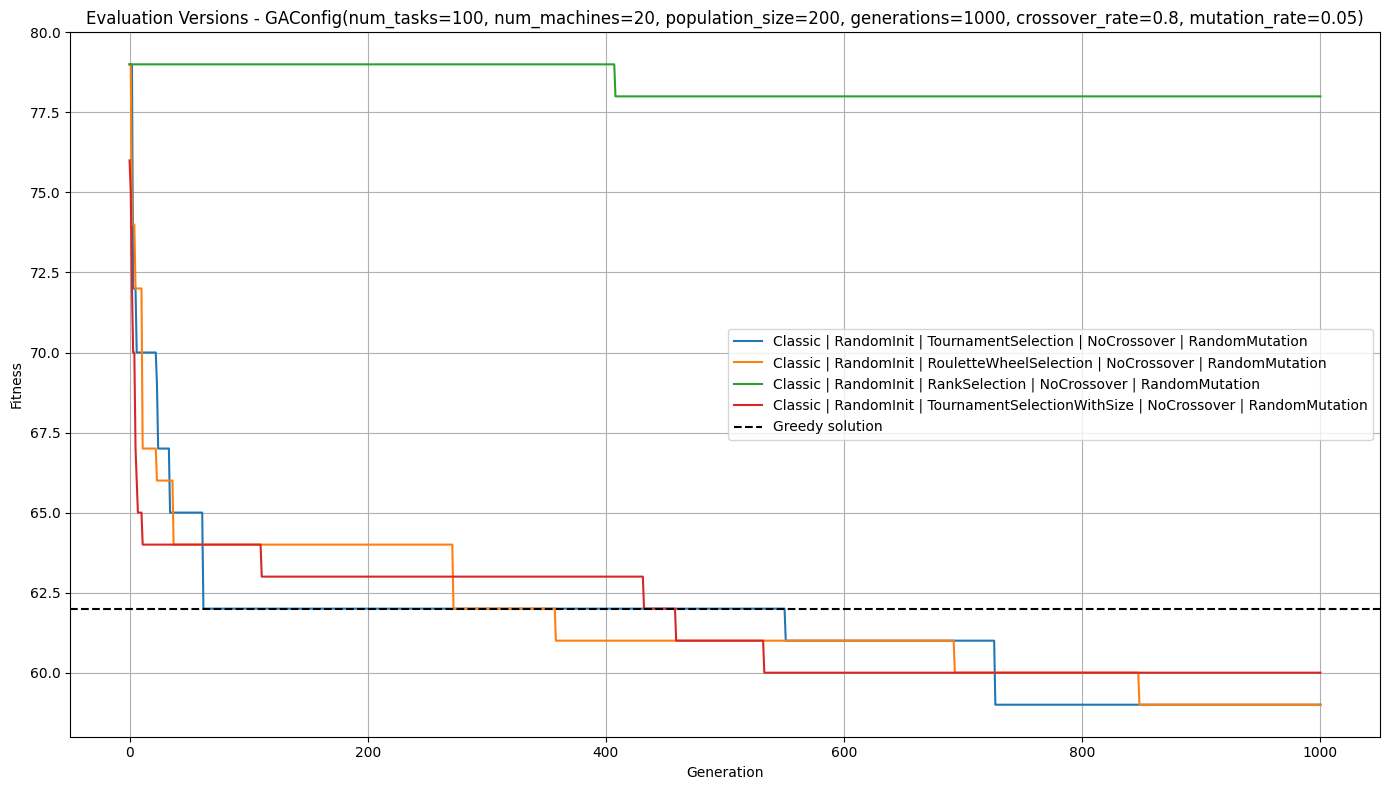

In [13]:
# Print final results
GAExperiment.print_results(results, greedy_result)

# Plot results
GAExperiment.plot_results(results, greedy_result)
# GAExperiment.subplot_results(results, greedy_result)


=== Running Classic | RandomInit | TournamentSelection | TwoPointCrossover | RandomMutation ===
Config: GAConfig(num_tasks=100, num_machines=20, population_size=200, generations=1000, crossover_rate=0.8, mutation_rate=0.01)
Generation   1: Best fitness = 74
Generation   2: Best fitness = 74
Generation   3: Best fitness = 74
Generation   4: Best fitness = 74
Generation   5: Best fitness = 74
Generation   6: Best fitness = 74
Generation   7: Best fitness = 74
Generation   8: Best fitness = 74
Generation   9: Best fitness = 74
Generation  10: Best fitness = 74
Generation  11: Best fitness = 74
Generation  12: Best fitness = 74
Generation  13: Best fitness = 73
Generation  14: Best fitness = 73
Generation  15: Best fitness = 71
Generation  16: Best fitness = 71
Generation  17: Best fitness = 71
Generation  18: Best fitness = 68
Generation  19: Best fitness = 66
Generation  20: Best fitness = 66
Generation  21: Best fitness = 66
Generation  22: Best fitness = 66
Generation  23: Best fitnes

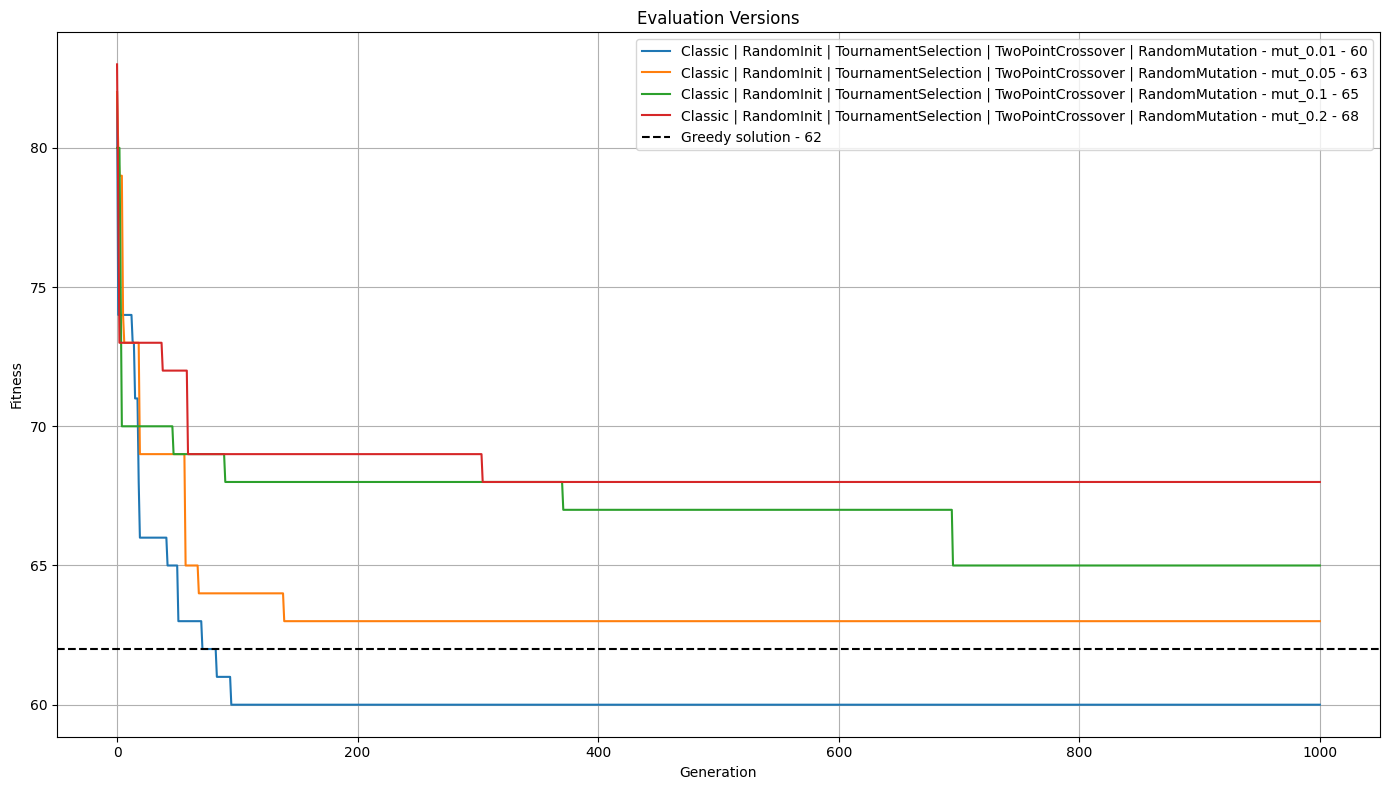

In [14]:
# ==================== Test Config ====================
config = GAConfig(
    num_tasks=100,
    num_machines=20,
    population_size=200,
    generations=1000,
    crossover_rate=0.8,
    mutation_rate=0.1
)

filter = [
    # evaluation_strategy | initialization_strategy | selection_strategy | crossover_strategy | mutation_strategy
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {NoCrossover.NAME} | {RandomMutation.NAME}",
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {TwoPointCrossover.NAME} | {NoMutation.NAME}",
    f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {TwoPointCrossover.NAME} | {RandomMutation.NAME}",
    # f"{ClassicEvaluation.NAME} | {RandomInitialization.NAME} | {TournamentSelection.NAME} | {TwoPointCrossover.NAME} | {GuidedMutation.NAME}",
]

def generate_config_variations(base_config):
    """Generate different configuration variations to test."""
    variations = []

    # Vary population size
    # for pop_size in [50, 100, 200]:
    #     new_config = replace(base_config)
    #     new_config.population_size = pop_size
    #     variations.append((f"pop_{pop_size}", new_config))

    # Vary generations number
    # for pop_size in [50, 100, 200, 500, 1000]:
    #     new_config = replace(base_config)
    #     new_config.generations = pop_size
    #     variations.append((f"gen_{pop_size}", new_config))

    # Vary mutation rate
    for mut_rate in [0.01, 0.05, 0.1, 0.2]:
        new_config = replace(base_config)
        new_config.mutation_rate = mut_rate
        variations.append((f"mut_{mut_rate}", new_config))

    # Vary crossover rate
    # for cross_rate in [0.5, 0.7, 0.9]:
    #     new_config = replace(base_config)
    #     new_config.crossover_rate = cross_rate
    #     variations.append((f"cross_{cross_rate}", new_config))

    return variations

tasks = [random.randint(1, 20) for _ in range(config.num_tasks)]
configs = generate_config_variations(config)
experiments = [(c[0], GAExperiment(c[1], filter, tasks)) for c in configs]
results = [(e[0], (e[1].run_both())) for e in experiments]

for gen_name, (result_dict, greedy_result) in results:
    GAExperiment.print_results(result_dict, greedy_result)
    # GAExperiment.plot_results(result_dict, greedy_result)

def plot_results_list(results):
    plt.figure(figsize=(14, 8))
    plt.plot()
    for n, r in results:
        results_list = r[0]
        greedy_result = r[1]
        results_list = {k:v for k,v in results_list.items()}
        for name, data in results_list.items():
            label=f"{name} - {n} - {data['history'][-1]}"
            plt.plot(data['history'], label=label)
    plt.axhline(y=greedy_result, color='black', linestyle='--', label=f"Greedy solution - {greedy_result}")
    plt.title("Evaluation Versions")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_results_list(results)